expver = 5 -> 1950 to 1978 and 2020 to present

expver = 1 -> 1979 to 2019

[Degree resulution to area](https://www.engr.scu.edu/~emaurer/tools/calc_cell_area_cgi.pl)

for 23lat = $705km^2$

[plot](https://dwikita-ichsana.medium.com/meteorology-101-how-to-download-and-plot-meteorological-data-from-era5-dcbf12553d6a)



In [1]:
import xarray as xr
from pprint import pprint
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import cdsapi
c = cdsapi.Client()

In [2]:
# finding the extend of a shape file
gdf = gpd.read_file(r"C:\Users\User\Desktop\New folder\new_temp.shp")
extent = gdf.geometry.total_bounds
right_down_corver, left_up_corner = extent[:2], extent[2:]
right_down_corver, left_up_corner

(array([89.42676891, 23.29497108]), array([90.22452602, 23.8742947 ]))

In [3]:
# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '2m_temperature', 'evaporation', 'total_precipitation',
#         ],
#         'year': [
#             '2018', '2024',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             left_up_corner[1], right_down_corver[0], right_down_corver[1],
#             left_up_corner[0],
#         ],
#     },
#     'era5.nc')

In [4]:
left_up_corner[1], right_down_corver[0], right_down_corver[1],left_up_corner[0],

(23.874294700280778, 89.42676891371673, 23.29497108454659, 90.22452602390807)

In [5]:
# read the netcdf file
ds2 = xr.open_dataset(
    "adaptor.mars.internal-1706449747.1128218-7520-9-fb699e35-c2d8-4407-9899-4f7f37246ab7.nc",
    # 'era5_tp',
    decode_times=True,
)

In [6]:
longitudes = ds2["longitude"].values
len_long = len(longitudes)
latitudes = ds2["latitude"].values
len_lat = len(latitudes)
len_long, len_lat

(5, 4)

In [7]:
points = []

for lon in longitudes:
    for lat in latitudes:
        points.append((lon, lat))

lat_long = np.array(points).reshape((len_lat, len_long, 2))
lat_long.shape

(4, 5, 2)

In [8]:
# extracting point from basin shape file
gdf = gpd.read_file(r"C:\Users\User\Desktop\New folder\new_temp.shp")
geometries = gdf["geometry"]

coordinates = []
for geometry in geometries:
    for point in geometry.exterior.coords[:]:
        coordinates.append(list(point))


point_of_geometry = np.array(coordinates)

In [9]:
# # finding the middle points
# middle_longs = []
# for i in range(len(longitudes) - 1):
#     middle_long = (longitudes[i] + longitudes[i + 1]) / 2
#     middle_longs.append(middle_long)

# middle_lats = []
# for i in range(len(latitudes) - 1):
#     middle_lat = (latitudes[i] + latitudes[i + 1]) / 2
#     middle_lats.append(middle_lat)

# mid_points = []

# for lat in middle_lats:
#     for lon in middle_longs:
#         mid_points.append((lon, lat))


# creating rectangle among middle points
# def create_rect(point, diff):
#     return (
#         point,
#         [point[0], point[1] + diff],
#         [point[0] + diff, point[1] + diff],
#         [point[0] + diff, point[1]],
#     )

# creating rectangle around the data points
def create_rect(point, diff):
    return (
        [point[0] - diff, point[1] + diff],
        [point[0] + diff, point[1] + diff],
        [point[0] + diff, point[1] - diff],
        [point[0] - diff, point[1] - diff],
    )


rects = []
for point in lat_long.reshape(-1, 2):
    rects.append(list(create_rect(point, 0.25 / 2)))
rects = np.array(rects)
rects = rects.reshape(len_lat, len_long, 4, 2)
rects.shape

(4, 5, 4, 2)

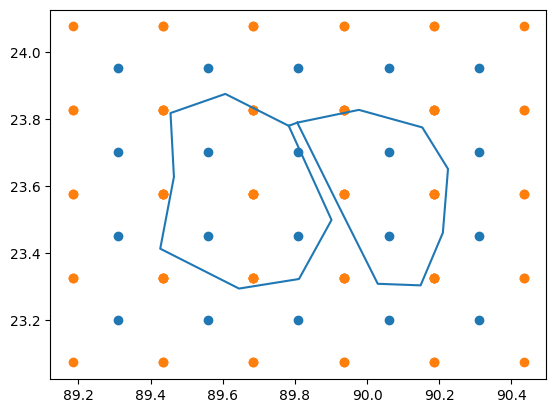

In [10]:
# plotting of the data points
x, y = lat_long[:, :, 0], lat_long[:, :, 1]
plt.scatter(x, y)

# plotting of the rectangles
x, y = rects[:, :, :, 0], rects[:, :, :, 1]
plt.scatter(x, y)

# plotting of the sub-basins
x_p, y_p = point_of_geometry[:, 0], point_of_geometry[:, 1]
plt.plot(x_p, y_p)

plt.show()

In [11]:
def find_area_between_polygon(polygon1, polygon2):
    intersection = polygon1.intersection(polygon2)
    return intersection.area

In [12]:
timestep = ds2['tp'].values.shape[0]
datetime_series = pd.Series(ds2['time'][0:timestep])
datetime_series = np.array(datetime_series, dtype=object)
# datetime_series

In [13]:
def extract_variable(var_name):
    one_basin_var = np.zeros((timestep, 1))
    all_basins_var = datetime_series.reshape((-1, 1))
    var_matrix = ds2['tp'].values
    removed_nan = var_matrix[~np.isnan(var_matrix)].reshape((timestep, len_lat, len_long)) # remove all the nan values and reduced the expver dimension
    
# find the var of all the sub-basins
    for geometry in geometries:
    # find the var of one sub-basin
        for i in range(len_lat):
            for j in range(len_long):
                one_tp = removed_nan[:, i, j].reshape(-1, 1)

                one_rect = Polygon(rects[i, j])
                rectangle_area = one_rect.area

                intersection_area = find_area_between_polygon(geometry, one_rect)

                weighted_var = (intersection_area / rectangle_area) * one_tp

                one_basin_var = np.concatenate(
                (one_basin_var, weighted_var.reshape(-1, 1)), axis=1
            )

        one_basin_var = np.sum(one_basin_var, axis=1).reshape(-1, 1)  # summing for all the grid
        all_basins_var = np.concatenate((all_basins_var, one_basin_var), axis=1) 
        one_basin_var = np.zeros((timestep, 1)) #resetting the initial values
    return all_basins_var

all_basins_tp = extract_variable('tp')

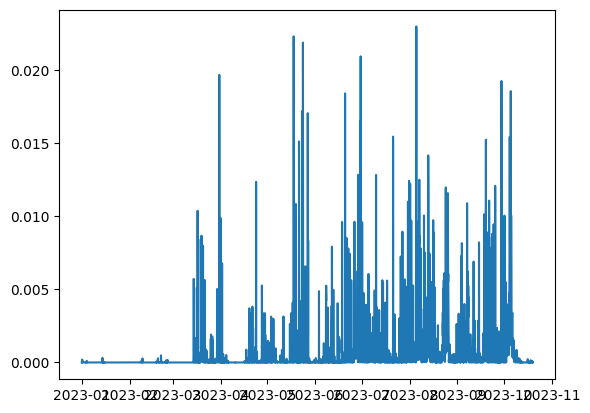

In [16]:
# one_ = all_basins_tp[:, 1]
plt.plot(all_basins_tp[:7000, 0], all_basins_tp[:7000, 1])

In [15]:
df = pd.DataFrame({
    'Time': all_basins_tp[:, 0],
    "id 0": all_basins_tp[:, 1],
    "id 1": all_basins_tp[:, 2]
})
df

,Time,id 0,id 1
0,2023-01-01 00:00:00,0.0,0.0
1,2023-01-01 01:00:00,0.0,0.0
2,2023-01-01 02:00:00,0.0,0.0
3,2023-01-01 03:00:00,0.0,0.0
4,2023-01-01 04:00:00,0.0,0.0
...,...,...,...
8755,2023-12-31 19:00:00,0.0,0.0
8756,2023-12-31 20:00:00,0.0,0.0
8757,2023-12-31 21:00:00,0.0,0.0
8758,2023-12-31 22:00:00,0.0,0.0
